Defect Type: Flash


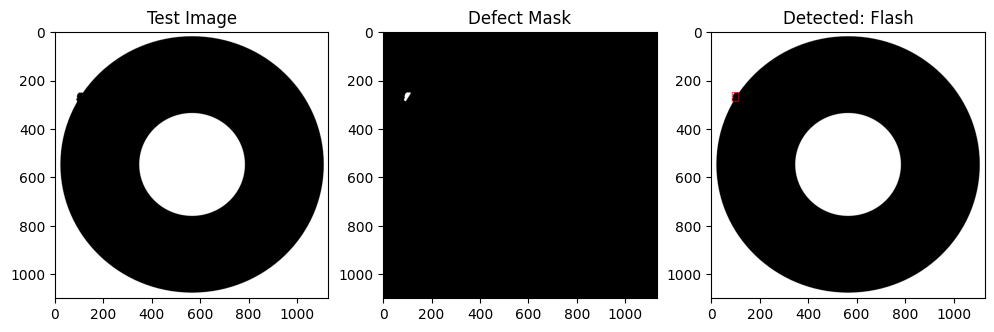

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    return blur

def get_outer_inner_contours(binary_img):
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    outer_contour = max(contours, key=cv2.contourArea)

    # Invert to get inner hole
    inv = cv2.bitwise_not(binary_img)
    inner_contours, _ = cv2.findContours(inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    inner_contour = max(inner_contours, key=cv2.contourArea)

    return outer_contour, inner_contour

def get_center(binary_img):
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_contour = max(contours, key=cv2.contourArea)
    M = cv2.moments(max_contour)
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])
    return (cx, cy)

def align_images(img_good, img_test):
    _, th_good = cv2.threshold(img_good, 127, 255, cv2.THRESH_BINARY_INV)
    _, th_test = cv2.threshold(img_test, 127, 255, cv2.THRESH_BINARY_INV)

    center_good = get_center(th_good)
    center_test = get_center(th_test)

    shift_x = center_good[0] - center_test[0]
    shift_y = center_good[1] - center_test[1]

    M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
    aligned_test = cv2.warpAffine(img_test, M, (img_test.shape[1], img_test.shape[0]))

    return aligned_test

def classify_defect(cnt, outer_contour, inner_contour):
    # Create masks
    mask_outer = np.zeros((1000, 1000), dtype=np.uint8)
    mask_inner = np.zeros((1000, 1000), dtype=np.uint8)
    cv2.drawContours(mask_outer, [outer_contour], -1, 255, -1)
    cv2.drawContours(mask_inner, [inner_contour], -1, 255, -1)

    mask_defect = np.zeros_like(mask_outer)
    cv2.drawContours(mask_defect, [cnt], -1, 255, -1)

    overlap_inner = cv2.countNonZero(cv2.bitwise_and(mask_defect, mask_inner))
    overlap_outer = cv2.countNonZero(cv2.bitwise_and(mask_defect, mask_outer))

    # Defect outside outer contour → Flash
    if overlap_outer < cv2.countNonZero(mask_defect):
        return "Flash"
    # Defect inside inner contour → Cut
    elif overlap_inner > 0:
        return "Cut"
    else:
        # Default: compare ratios
        if overlap_inner > (overlap_outer - overlap_inner):
            return "Cut"
        else:
            return "Flash"

def detect_defect(img_good_color, img_test_color):
    img_good = preprocess(img_good_color)
    img_test = preprocess(img_test_color)

    aligned_test = align_images(img_good, img_test)

    diff = cv2.absdiff(img_good, aligned_test)
    _, mask = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)

    _, th_good = cv2.threshold(img_good, 127, 255, cv2.THRESH_BINARY_INV)
    outer_contour, inner_contour = get_outer_inner_contours(th_good)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    output_img = img_test_color.copy()
    defect_type = None

    for cnt in contours:
        if cv2.contourArea(cnt) < 10:
            continue
        defect_type = classify_defect(cnt, outer_contour, inner_contour)
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(output_img, (x, y), (x + w, y + h), (0, 0, 255), 2)

    return output_img, mask, defect_type


good_img = cv2.imread("/content/good.png")
flash_img = cv2.imread("/content/defect4.png")

result_img, defect_mask, defect_class = detect_defect(good_img, flash_img)

print("Defect Type:", defect_class)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); plt.imshow(cv2.cvtColor(flash_img, cv2.COLOR_BGR2RGB)); plt.title("Test Image")
plt.subplot(1, 3, 2); plt.imshow(defect_mask, cmap='gray'); plt.title("Defect Mask")
plt.subplot(1, 3, 3); plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)); plt.title(f"Detected: {defect_class}")
plt.show()
